### LSTM Model

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people. They work tremendously well on a large variety of problems – including also timeseries forecast -, and are now widely used. There is an excellent article explaining [LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [3]:
from utils import split_sequence, get_apple_close_price, plot_series
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
apple_close_price = get_apple_close_price()

TODO: data trasnformation here

In [194]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam, RMSprop

import warnings
warnings.simplefilter('ignore')

In [195]:
def build_model(units=100, activation='tanh', lr=0.001, look_back=1, output=1, n_features=1, dropout=.2):
    model = Sequential()

    model.add(LSTM(units, 
                   activation=activation, 
                   return_sequences=True, 
                   input_shape=(look_back, n_features)))
    model.add(Dropout(dropout))
    model.add(LSTM(units, 
                   activation=activation, 
                   return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units, 
                   activation=activation, 
                   return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(output))

    model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error')
    
    return model

In [231]:
LSTMmodel = build_model(lr=0.0001, look_back=look_back)

In [232]:
LSTMmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
dropout_37 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 3, 100)            80400     
_________________________________________________________________
dropout_38 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 3, 100)            80400     
_________________________________________________________________
dropout_39 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 100)               80400     
__________

In [233]:
history = LSTMmodel.fit(X_train, y_train, epochs=n_epochs, batch_size=n_batch, shuffle=False)

Epoch 1/100
9211/9211 [==============================] - 14s 1ms/step - loss: 0.0522
Epoch 2/100
9211/9211 [==============================] - 3s 338us/step - loss: 0.0506
Epoch 3/100
9211/9211 [==============================] - 3s 335us/step - loss: 0.0450
Epoch 4/100
9211/9211 [==============================] - 3s 302us/step - loss: 0.0287
Epoch 5/100
9211/9211 [==============================] - 3s 320us/step - loss: 0.0067
Epoch 6/100
9211/9211 [==============================] - 3s 318us/step - loss: 0.0011
Epoch 7/100
9211/9211 [==============================] - 3s 319us/step - loss: 0.0011
Epoch 8/100
9211/9211 [==============================] - 3s 324us/step - loss: 9.8181e-04
Epoch 9/100
9211/9211 [==============================] - 3s 318us/step - loss: 8.4221e-04
Epoch 10/100
9211/9211 [==============================] - 3s 320us/step - loss: 8.0946e-04
Epoch 11/100
9211/9211 [==============================] - 3s 311us/step - loss: 7.8852e-04
Epoch 12/100
9211/9211 [=============

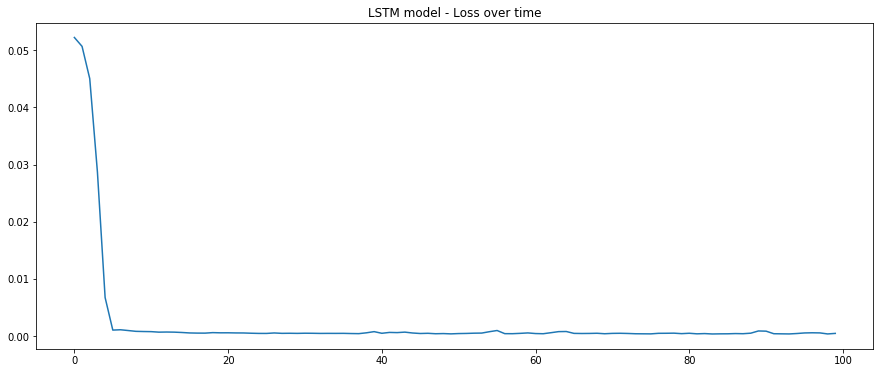

In [258]:
plot_series(history.history['loss'], title='LSTM model - Loss over time')

In [259]:
# walk-forward validation
def LSTM_walk_forward(model, X, y, size=1, steps=1, debug=True):
    predictions = list()
    limit_range = len(X[:size])

    for t in range(0, limit_range, steps):
        x_input = X[t]
        x_input = x_input.reshape(1, x_input.shape[0], x_input.shape[1])
        y_output = model.predict(x_input)
        predicted = y_output.reshape(steps,)
        expected = y[t:t+steps].reshape(steps,)
        
        predictions.append(predicted)
        
        if debug == True:
            print('predicted={}, expected={}'.format(predicted, expected))
            
    return np.array(predictions)

In [260]:
size = 21 # (approx. one month) and 1 day prediction by default
predictions = LSTM_walk_forward(LSTMmodel, X_test, y_test, size=size)

predicted=[0.93682855], expected=[0.9225162]
predicted=[0.94195026], expected=[0.91918078]
predicted=[0.9336107], expected=[0.92296514]
predicted=[0.93437344], expected=[0.9142418]
predicted=[0.932691], expected=[0.9235424]
predicted=[0.93343854], expected=[0.92918695]
predicted=[0.93064094], expected=[0.93220164]
predicted=[0.9381249], expected=[0.93354866]
predicted=[0.9425199], expected=[0.94656953]
predicted=[0.9455481], expected=[0.95471552]
predicted=[0.9501643], expected=[0.95805094]
predicted=[0.9605313], expected=[0.96138636]
predicted=[0.96662503], expected=[0.96741574]
predicted=[0.9698825], expected=[0.96305402]
predicted=[0.9731813], expected=[0.96260508]
predicted=[0.97580034], expected=[0.97427891]
predicted=[0.97368973], expected=[0.97844821]
predicted=[0.9765482], expected=[0.98306646]
predicted=[0.98503613], expected=[0.96446516]
predicted=[0.9876337], expected=[0.9576661]
predicted=[0.9854979], expected=[0.95272713]


We need to revert the scaling and transformation:

In [261]:
def revert_transformations(test, predictions):
    original_y_test = scaler.inverse_transform(test)
    original_predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

#     original_y_test = np.power(original_y_test, 4)
#     original_predictions = np.power(original_predictions, 4)

#     original_y_test = np.exp(original_y_test)
#     original_predictions = np.exp(original_predictions)

#     original_y_test = inv_boxcox(original_y_test, lmbda)
#     original_predictions = inv_boxcox(original_predictions, lmbda)
    
    return original_y_test, original_predictions

In [262]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)

In [263]:
from utils import rmse, plot_walk_forward_validation

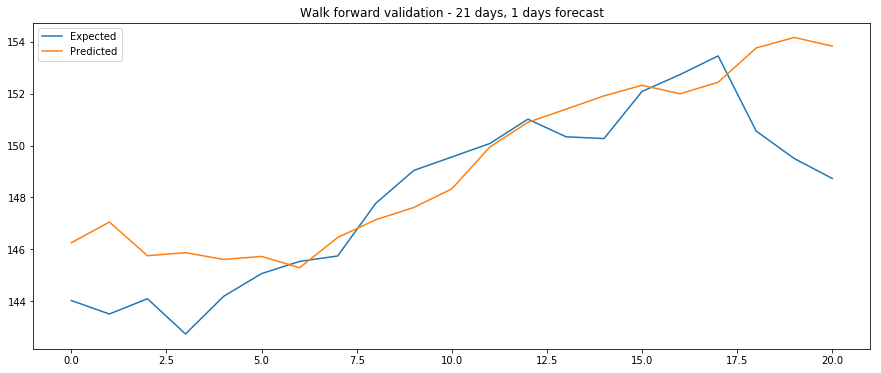

In [264]:
plot_walk_forward_validation(original_y_test, original_predictions, size)

In [241]:
print('LSTM[%d days, %d day forecast] - RMSE: %.3f' % (size, 1, rmse(original_predictions, original_y_test[:size])))

LSTM[21 days, 1 day forecast] - RMSE: 2.192


For multiple steps, I'm gonna use [Recursive Multi-step Forecast](https://machinelearningmastery.com/multi-step-time-series-forecasting/) strategy

In [242]:
# walk-forward validation by looping over the steps
def LSTM_walk_forward_by_looping(model, X, y, size=1, steps=1, debug=True):
    predictions = list()
    limit_range = len(X[:size])
    look_back = X[0].shape[0]
    n_features = X[0].shape[1]

    for t in range(0, limit_range, steps):
        x_input = X[t]
        x_input = x_input.reshape(1, look_back, n_features)
        
        step_predictions = []
        
        for p in range(steps):
            y_output = LSTMmodel.predict(x_input)
            
            out_val = y_output.item(0)
            step_predictions.append(out_val)
            
            in_vals = x_input.flatten()[1:] # gets rid of the first price
            in_vals = np.append(in_vals, out_val) # appends the new predicted price
            
            x_input = in_vals.reshape(1, look_back, n_features)
            
        predicted = np.array(step_predictions).reshape(steps,)
        expected = y[t:t+steps].reshape(steps,)
        
        predictions.append(predicted)
        
        if debug == True:
            print('predicted={}, expected={}'.format(predicted, expected))
            
    return np.array(predictions)

In [243]:
size = 21 # (approx. one month)
steps = 3 # 3 days prediction
predictions = LSTM_walk_forward_by_looping(LSTMmodel, X_test, y_test, size=size, steps=steps)

predicted=[0.93682855 0.94282699 0.93869239], expected=[0.9225162  0.91918078 0.92296514]
predicted=[0.93437344 0.9339326  0.93918043], expected=[0.9142418  0.9235424  0.92918695]
predicted=[0.93064094 0.93802911 0.94240004], expected=[0.93220164 0.93354866 0.94656953]
predicted=[0.94554812 0.94960707 0.95773035], expected=[0.95471552 0.95805094 0.96138636]
predicted=[0.96662503 0.96983516 0.97338969], expected=[0.96741574 0.96305402 0.96260508]
predicted=[0.97580034 0.97378039 0.97664684], expected=[0.97427891 0.97844821 0.98306646]
predicted=[0.98503613 0.98884428 0.99237847], expected=[0.96446516 0.9576661  0.95272713]


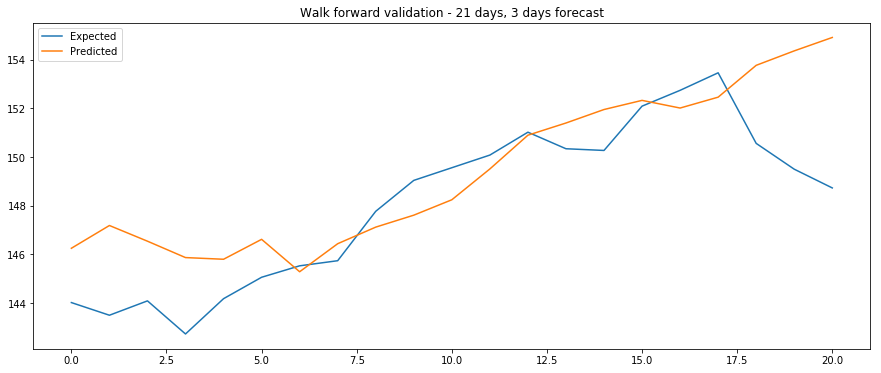

In [244]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)
plot_walk_forward_validation(original_y_test, original_predictions, size, steps)

In [245]:
print('LSTM[%d days, %d day forecast] - RMSE: %.3f' % (size, steps, rmse(original_predictions, original_y_test[:size])))

LSTM[21 days, 3 day forecast] - RMSE: 2.413


In [246]:
size = 21 # approx. one month
steps = 7 # 7 days prediction
predictions = LSTM_walk_forward_by_looping(LSTMmodel, X_test, y_test, size=size, steps=steps)

predicted=[0.93682855 0.94282699 0.93869239 0.950302   0.95371944 0.95425528
 0.96237612], expected=[0.9225162  0.91918078 0.92296514 0.9142418  0.9235424  0.92918695
 0.93220164]
predicted=[0.9381249  0.94279993 0.94647104 0.95157892 0.9557296  0.95954657
 0.96398914], expected=[0.93354866 0.94656953 0.95471552 0.95805094 0.96138636 0.96741574
 0.96305402]
predicted=[0.97318131 0.97642964 0.97643405 0.9834736  0.9858861  0.98775911
 0.99277192], expected=[0.96260508 0.97427891 0.97844821 0.98306646 0.96446516 0.9576661
 0.95272713]


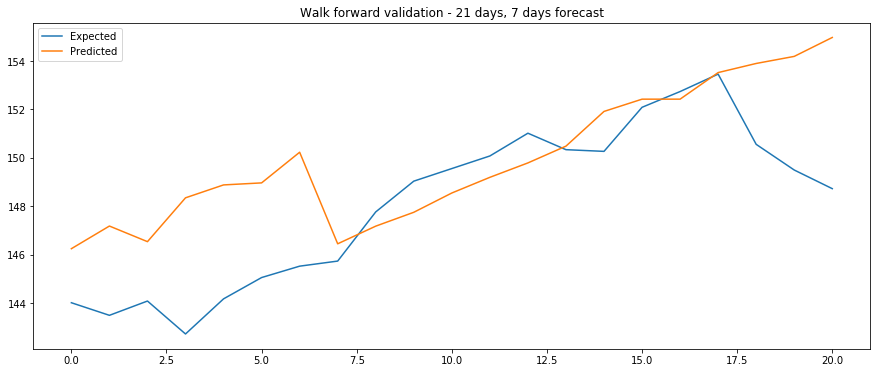

In [247]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)
plot_walk_forward_validation(original_y_test, original_predictions, size, steps)

In [248]:
print('LSTM[%d days, %d day forecast] - RMSE: %.3f' % (size, steps, rmse(original_predictions, original_y_test[:size])))

LSTM[21 days, 7 day forecast] - RMSE: 3.060


In [249]:
size = 21 # approx. one month
steps = 21 # 21 days prediction
predictions = LSTM_walk_forward_by_looping(LSTMmodel, X_test, y_test, size=size, steps=steps)

predicted=[0.93682855 0.94282699 0.93869239 0.950302   0.95371944 0.95425528
 0.96237612 0.96512145 0.96763885 0.97349823 0.97616583 0.97932392
 0.98377419 0.98645157 0.98963767 0.99320406 0.9958269  0.9987933
 1.00177634 1.00426507 1.00693369], expected=[0.9225162  0.91918078 0.92296514 0.9142418  0.9235424  0.92918695
 0.93220164 0.93354866 0.94656953 0.95471552 0.95805094 0.96138636
 0.96741574 0.96305402 0.96260508 0.97427891 0.97844821 0.98306646
 0.96446516 0.9576661  0.95272713]


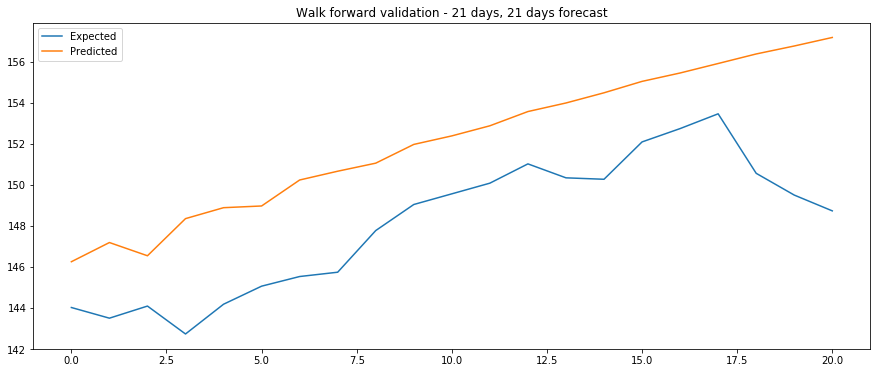

In [250]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)
plot_walk_forward_validation(original_y_test, original_predictions, size, steps)

In [251]:
print('LSTM[%d days, %d day forecast] - RMSE: %.3f' % (size, steps, rmse(original_predictions, original_y_test[:size])))

LSTM[21 days, 21 day forecast] - RMSE: 4.325


In [252]:
size = 42 # approx. two months
steps = 42 # 42 days prediction
predictions = LSTM_walk_forward_by_looping(LSTMmodel, X_test, y_test, size=size, steps=steps)

predicted=[0.93682855 0.94282699 0.93869239 0.950302   0.95371944 0.95425528
 0.96237612 0.96512145 0.96763885 0.97349823 0.97616583 0.97932392
 0.98377419 0.98645157 0.98963767 0.99320406 0.9958269  0.9987933
 1.00177634 1.00426507 1.00693369 1.00949895 1.01179838 1.01416314
 1.01640153 1.01848519 1.02056623 1.02253115 1.02439368 1.02621877
 1.0279454  1.02959454 1.03119159 1.0327065  1.0341568  1.03555179
 1.03687787 1.03814721 1.03936327 1.04052103 1.04162812 1.0426861 ], expected=[0.9225162  0.91918078 0.92296514 0.9142418  0.9235424  0.92918695
 0.93220164 0.93354866 0.94656953 0.95471552 0.95805094 0.96138636
 0.96741574 0.96305402 0.96260508 0.97427891 0.97844821 0.98306646
 0.96446516 0.9576661  0.95272713 0.96119394 1.00667074 0.99660047
 1.00186008 1.01738249 1.02552857 1.03181448 0.99499691 1.00885156
 1.02405333 1.03527822 1.03110891 1.011289   1.00897987 1.00711979
 1.02360429 1.02488711 1.02033307 1.02411744 1.03444433 1.04368083]


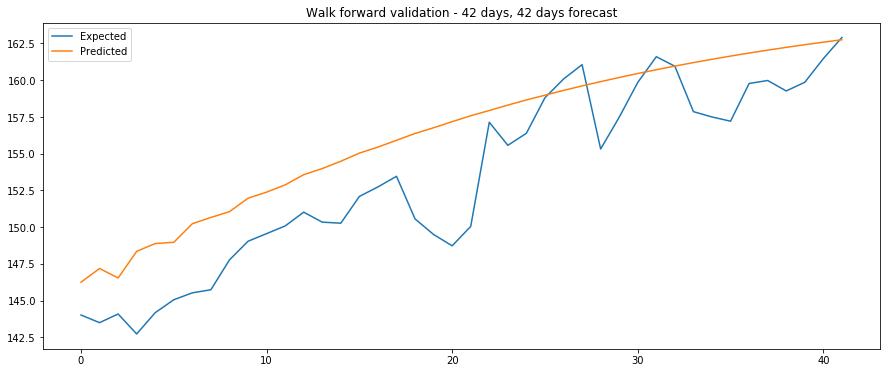

In [253]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)
plot_walk_forward_validation(original_y_test, original_predictions, size, steps)

In [254]:
print('LSTM[%d days, %d day forecast] - RMSE: %.3f' % (size, steps, rmse(original_predictions, original_y_test[:size])))

LSTM[42 days, 42 day forecast] - RMSE: 3.672


In [255]:
size = 252 # approx. one year
steps = 252 # 252 days prediction
predictions = LSTM_walk_forward_by_looping(LSTMmodel, X_test, y_test, size=size, steps=steps)

predicted=[0.93682855 0.94282699 0.93869239 0.950302   0.95371944 0.95425528
 0.96237612 0.96512145 0.96763885 0.97349823 0.97616583 0.97932392
 0.98377419 0.98645157 0.98963767 0.99320406 0.9958269  0.9987933
 1.00177634 1.00426507 1.00693369 1.00949895 1.01179838 1.01416314
 1.01640153 1.01848519 1.02056623 1.02253115 1.02439368 1.02621877
 1.0279454  1.02959454 1.03119159 1.0327065  1.0341568  1.03555179
 1.03687787 1.03814721 1.03936327 1.04052103 1.04162812 1.0426861
 1.04369414 1.04465711 1.04557598 1.04645169 1.04728734 1.04808414
 1.04884326 1.0495671  1.05025685 1.05091381 1.05154002 1.05213606
 1.05270374 1.05324459 1.05375922 1.05424917 1.05471575 1.05515945
 1.05558193 1.0559839  1.05636621 1.05673027 1.05707633 1.05740559
 1.05771887 1.05801654 1.05829978 1.05856919 1.05882514 1.05906856
 1.05930018 1.05952013 1.05972934 1.0599283  1.06011724 1.06029689
 1.06046772 1.06062996 1.06078422 1.06093073 1.0610702  1.06120253
 1.06132829 1.06144786 1.06156147 1.06166935 1.0617717

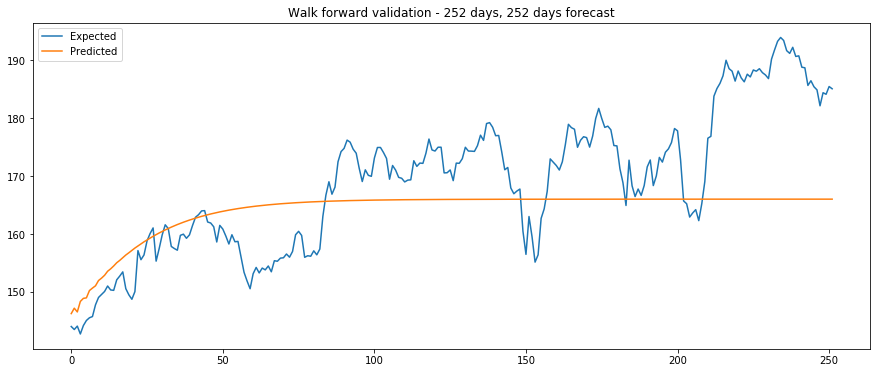

In [256]:
original_y_test, original_predictions = revert_transformations(y_test, predictions)
plot_walk_forward_validation(original_y_test, original_predictions, size, steps)

In [257]:
print('LSTM[%d days, %d day forecast] - RMSE: %.3f' % (size, steps, rmse(original_predictions, original_y_test[:size])))

LSTM[252 days, 252 day forecast] - RMSE: 11.025
